# Train VAE with samples from 1d GP on a regular grid

In [1]:
#!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro

In [2]:
import numpyro

In [3]:
# general libraries
import time
import os
import math
import numpy as np
import matplotlib.pyplot as plt

# JAX
import jax.numpy as jnp
from jax import random, lax, jit, ops
from jax.experimental import stax

from functools import partial

# Numpyro
import numpyro
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import SVI, Trace_ELBO, MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi

import pickle

## GP priors

In [4]:
def dist_euclid(x, z):
    x = jnp.array(x) 
    z = jnp.array(z)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1)
    if len(z.shape)==1:
        z = x.reshape(x.shape[0], 1)
    n_x, m = x.shape
    n_z, m_z = z.shape
    assert m == m_z
    delta = jnp.zeros((n_x,n_z))
    for d in jnp.arange(m):
        x_d = x[:,d]
        z_d = z[:,d]
        delta += (x_d[:,jnp.newaxis] - z_d)**2
    return jnp.sqrt(delta)


def exp_sq_kernel(x, z, var, length, noise=0, jitter=1.0e-6):
    dist = dist_euclid(x, z)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k


def GP(gp_kernel, x, jitter=1e-5, var=None, length=None, y=None, noise=False):
    
    if length==None:
        length = numpyro.sample("kernel_length", dist.InverseGamma(4,1))
        
    if var==None:
        var = numpyro.sample("kernel_var", dist.LogNormal(0.,0.1))
        
    k = gp_kernel(x, x, var, length, jitter)
    
    if noise==False:
        numpyro.sample("y",  dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k), obs=y)
    else:
        sigma = numpyro.sample("noise", dist.HalfNormal(0.1))
        f = numpyro.sample("f", dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))
        numpyro.sample("y", dist.Normal(f, sigma), obs=y)

In [5]:
def plot_draws(draws, ttl="Priors we want to encode", ylbl='$y=f_{GP}(x)$'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in range(draws.shape[0]):
        ax.plot(x, draws[i,:])
        if i>30: break
    ax.set_xlabel('$x$')
    ax.set_ylabel(ylbl)
    ax.set_title(ttl)

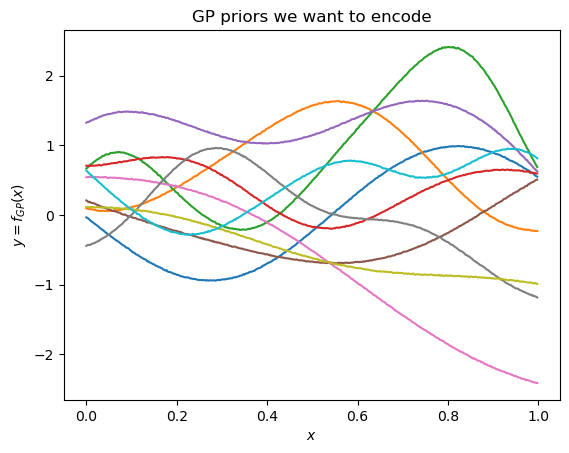

In [6]:
args = {"n": 400,
        "gp_kernel": exp_sq_kernel,
        "rng_key": random.PRNGKey(2),
        "batch_size": 10
}

# create grid and draw priors
x = jnp.arange(0, 1, 1/args["n"])
rng_key, rng_key_predict = random.split(random.PRNGKey(4))
gp_predictive = Predictive(GP, num_samples=args["batch_size"])
gp_draws = gp_predictive(rng_key_predict, x=x, gp_kernel = args["gp_kernel"], jitter=1e-5)['y']
plot_draws(gp_draws, ttl='GP priors we want to encode')

#n = args["n"]
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_n{}_GP_priors.pdf'.format(n))

## Train VAE

In [7]:
def vae_encoder(hidden_dim1, hidden_dim2, z_dim):
    return stax.serial(
        stax.Dense(hidden_dim1, W_init=stax.randn()),
        stax.Relu,
        stax.Dense(hidden_dim2, W_init=stax.randn()),
        stax.Relu,
        stax.FanOut(2),
        stax.parallel(
            stax.Dense(z_dim, W_init=stax.randn()), # mean
            stax.serial(stax.Dense(z_dim, W_init=stax.randn()), stax.Exp), # std -- i.e. diagonal covariance
        ),
    )


def vae_decoder(hidden_dim1, hidden_dim2, out_dim):
    return stax.serial(
        stax.Dense(hidden_dim1, W_init=stax.randn()),
        stax.Relu,
        stax.Dense(hidden_dim2, W_init=stax.randn()),
        stax.Relu,
        stax.Dense(out_dim, W_init=stax.randn()) 
    )


def vae_model(batch, hidden_dim1, hidden_dim2, z_dim):
    batch = jnp.reshape(batch, (batch.shape[0], -1))
    batch_dim, out_dim = jnp.shape(batch)
    decode = numpyro.module("decoder", vae_decoder(hidden_dim1, hidden_dim2, out_dim), (batch_dim, z_dim))
    z = numpyro.sample("z", dist.Normal(jnp.zeros((z_dim,)), jnp.ones((z_dim,))))
    gen_loc = decode(z)    
    return numpyro.sample("obs", dist.Normal(gen_loc, args["vae_var"]), obs=batch) 
    

def vae_guide(batch, hidden_dim1, hidden_dim2, z_dim):
    batch = jnp.reshape(batch, (batch.shape[0], -1))
    batch_dim, out_dim = jnp.shape(batch)
    encode = numpyro.module("encoder", vae_encoder(hidden_dim1, hidden_dim2, z_dim), (batch_dim, out_dim))
    z_loc, z_std = encode(batch)
    z = numpyro.sample("z", dist.Normal(z_loc, z_std))
    return z

@jit
def epoch_train(rng_key, svi_state, num_train):

    def body_fn(i, val):
        rng_key_i = random.fold_in(rng_key, i) 
        rng_key_i, rng_key_ls, rng_key_var, rng_key_noise = random.split(rng_key_i, 4)
        loss_sum, svi_state = val # val -- svi_state
        batch = gp_predictive(rng_key_i, gp_kernel=args["gp_kernel"], x=args["x"], jitter=1e-4)
        svi_state, loss = svi.update(svi_state, batch['y']) 
        loss_sum += loss / args['batch_size']
        return loss_sum, svi_state

    return lax.fori_loop(0, num_train, body_fn, (0.0, svi_state)) #fori_loop(lower, upper, body_fun, init_val)

@jit
def eval_test(rng_key, svi_state, num_test):

    def body_fn(i, loss_sum):
        rng_key_i = random.fold_in(rng_key, i) 
        rng_key_i, rng_key_ls, rng_key_var, rng_key_noise = random.split(rng_key_i, 4)
        batch = gp_predictive(rng_key_i, gp_kernel=args["gp_kernel"], x=args["x"], jitter=1e-4)
        loss = svi.evaluate(svi_state, batch['y']) / args['batch_size']
        loss_sum += loss
        return loss_sum

    loss = lax.fori_loop(0, num_test, body_fn, 0.0)
    loss = loss / num_test

    return loss

In [8]:
args = {"num_epochs": 50, 
        "learning_rate": 1.0e-3, 
        "batch_size": 100, 
        "hidden_dim1": 35,
        "hidden_dim2": 30,
        "z_dim": 30,
         "x": x,
        "n": 400,
        "gp_kernel": exp_sq_kernel,
        "rng_key": random.PRNGKey(1),
        "num_warmup": 1000,
        "num_samples": 1000,
        "num_chains": 4,
        "thinning": 1,
        "vae_var": 0.1
        }

In [9]:
adam = optim.Adam(step_size=args["learning_rate"])

svi = SVI(vae_model, vae_guide, adam, Trace_ELBO(), 
          hidden_dim1=args["hidden_dim1"], 
          hidden_dim2=args["hidden_dim2"], 
          z_dim=args["z_dim"])

rng_key, rng_key_samp, rng_key_init = random.split(args["rng_key"], 3)
init_batch = gp_predictive(rng_key_predict, x=args["x"], gp_kernel = args["gp_kernel"])['y']
svi_state = svi.init(rng_key_init, init_batch)

In [10]:
test_loss_list = []

for i in range(args['num_epochs']):
    
    rng_key, rng_key_train, rng_key_test, rng_key_infer = random.split(rng_key, 4)
    
    t_start = time.time()

    num_train = 1000
    _, svi_state = epoch_train(rng_key_train, svi_state, num_train)

    num_test = 1000
    test_loss = eval_test(rng_key_test, svi_state, num_test)
    test_loss_list += [test_loss]

    print(
        "Epoch {}: loss = {} ({:.2f} s.)".format(
            i, test_loss, time.time() - t_start
        )
    )
    
    if math.isnan(test_loss): break

Epoch 0: loss = 848.076904296875 (35.32 s.)
Epoch 1: loss = 837.5844116210938 (26.31 s.)
Epoch 2: loss = 828.0806884765625 (26.17 s.)
Epoch 3: loss = 833.9554443359375 (26.24 s.)
Epoch 4: loss = 820.1657104492188 (26.37 s.)
Epoch 5: loss = 839.7373046875 (26.42 s.)
Epoch 6: loss = 823.3922119140625 (26.35 s.)
Epoch 7: loss = 815.5242309570312 (26.44 s.)
Epoch 8: loss = 819.5936889648438 (26.27 s.)
Epoch 9: loss = 809.7528076171875 (26.43 s.)
Epoch 10: loss = 328.7407531738281 (26.36 s.)
Epoch 11: loss = 198.2872314453125 (23.34 s.)
Epoch 12: loss = 114.16166687011719 (19.82 s.)
Epoch 13: loss = 114.72335052490234 (19.31 s.)
Epoch 14: loss = 108.57937622070312 (18.87 s.)
Epoch 15: loss = 102.72244262695312 (18.71 s.)
Epoch 16: loss = 109.47850036621094 (18.75 s.)
Epoch 17: loss = 52.48612594604492 (18.68 s.)
Epoch 18: loss = 20.367887496948242 (18.64 s.)
Epoch 19: loss = 19.554983139038086 (18.50 s.)
Epoch 20: loss = 20.038280487060547 (18.47 s.)
Epoch 21: loss = 16.466642379760742 (18.

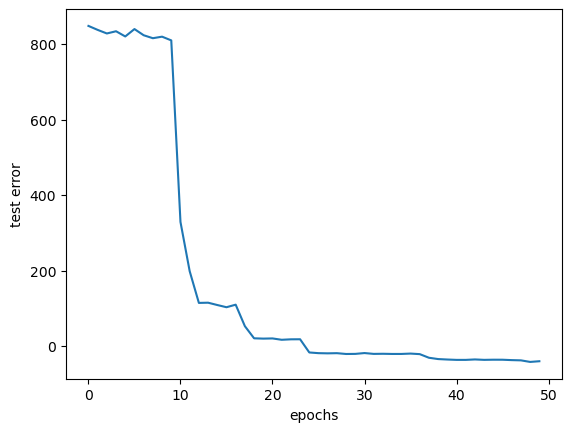

In [11]:
plt.figure()
plt.plot(np.arange(len(test_loss_list)), test_loss_list, label="test loss")
plt.xlabel("epochs")
plt.ylabel("test error")
plt.show()

In [12]:
# Save after training

decoder_params = svi.get_params(svi_state)["decoder$params"]
args["decoder_params"] = decoder_params

#with open('decoders/decoder_1d_n400', 'wb') as file:
#    pickle.dump(decoder_params, file)

In [13]:
# Load 
#with open('decoders/decoder_1d_n400', 'rb') as file:
#    decoder_params = pickle.load(file)
#    print(len(decoder_params))

#args["decoder_params"] = decoder_params

## Plot what VAE has learnt

In [14]:
def vae_sample(z_dim=args["z_dim"]):
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    decoder_nn = vae_decoder(args["hidden_dim2"], args["hidden_dim1"], len(args["x"]))  
    decoder_params = args["decoder_params"]
    f = numpyro.deterministic("f", decoder_nn[1](decoder_params, z))

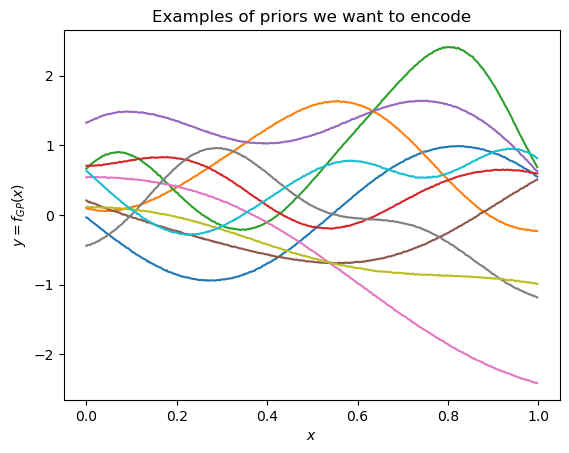

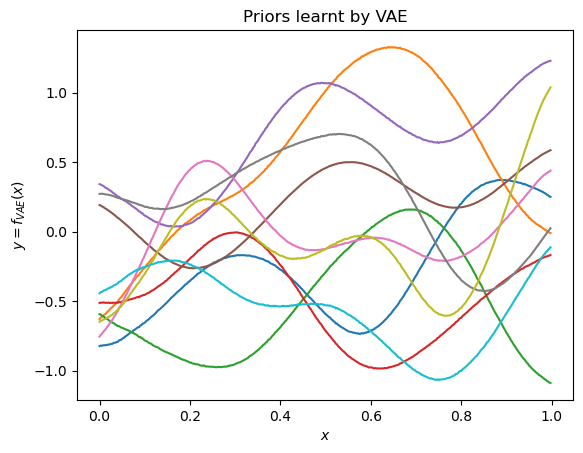

In [15]:
rng_key, rng_key_predict = random.split(random.PRNGKey(2))
vae_predictive = Predictive(vae_sample, num_samples=10)
vae_draws = vae_predictive(rng_key_predict)['f']

plot_draws(gp_draws, ttl='Examples of priors we want to encode')
plot_draws(vae_draws, ttl='Priors learnt by VAE', ylbl='$y=f_{VAE}(x)$')

In [16]:
#plot_draws(vae_draws, ttl='Priors learnt by VAE', ylbl='$y=f_{VAE}(x)$')

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_n{}_VAE_priors.pdf'.format(n))

Text(0.5, 1.0, 'Priors learnt by VAE')

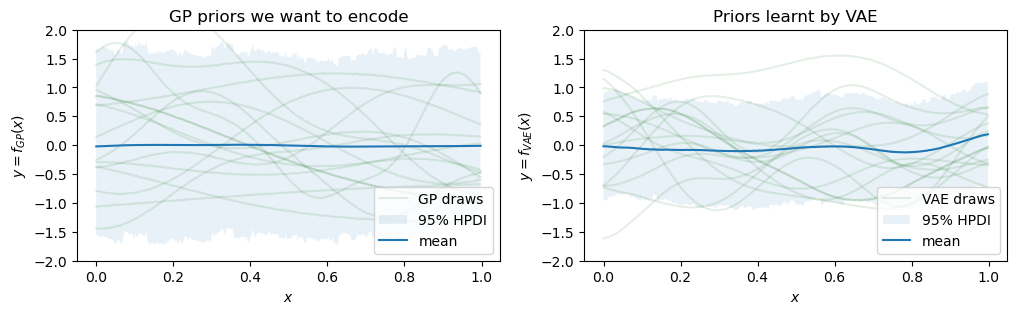

In [17]:
# generate draws

x = jnp.arange(0, 1, 1/args["n"])
rng_key, rng_key_predict = random.split(random.PRNGKey(6))
gp_predictive = Predictive(GP, num_samples=1000)
gp_draws = gp_predictive(rng_key_predict, x=x, gp_kernel = args["gp_kernel"], jitter=1e-5)['y']

rng_key, rng_key_predict = random.split(random.PRNGKey(6))
vae_predictive = Predictive(vae_sample, num_samples=1000)
vae_draws = vae_predictive(rng_key_predict)['f']


# plot results
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

_min, _max = -2, 2
lines_alpha_gp = 0.1
lines_alpha_vae = 0.1
N_lines = 15

#-----------------------
gp_draws = gp_draws[~np.isnan(gp_draws).any(axis=1), :]
mean_gp = jnp.nanmean(gp_draws, axis=0)
hpdi_gp = hpdi(gp_draws, 0.9)

ttl="GP priors we want to encode"
ylbl='$y=f_{GP}(x)$'

for j in range(N_lines):
    axs[0].plot(args["x"], gp_draws[j,:], alpha=lines_alpha_gp, color="darkgreen", label="")
axs[0].plot(args["x"], gp_draws[0,:], alpha=lines_alpha_gp, color="darkgreen", label="GP draws")  
axs[0].fill_between(args["x"], hpdi_gp[0], hpdi_gp[1], alpha=0.1, interpolate=True, label="95% HPDI")
#axs[0].plot(args["x"], mean_gp, color="brown", label="mean")
axs[0].plot(args["x"], mean_gp, label="mean")
axs[0].legend(loc=4)
axs[0].set_ylim([_min, _max])
axs[0].set_xlabel('$x$')
axs[0].set_ylabel(ylbl)
axs[0].set_title(ttl)


#-----------------------
mean_vae = jnp.nanmean(vae_draws, axis=0)
hpdi_vae = hpdi(vae_draws, 0.9)

ttl='Priors learnt by VAE'
ylbl='$y=f_{VAE}(x)$'

for j in range(N_lines):
    axs[1].plot(args["x"], vae_draws[j,:], alpha=lines_alpha_vae, color="darkgreen", label="")
axs[1].plot(args["x"], vae_draws[0,:], alpha=lines_alpha_vae, color="darkgreen", label="VAE draws")  
axs[1].fill_between(args["x"], hpdi_vae[0], hpdi_vae[1], alpha=0.1, interpolate=True, label="95% HPDI")
#axs[1].plot(args["x"], mean_vae, color="brown", label="mean")
axs[1].plot(args["x"], mean_vae, label="mean")
axs[1].legend(loc=4)
axs[1].set_ylim([_min, _max])
axs[1].set_xlabel('$x$')
axs[1].set_ylabel(ylbl)
axs[1].set_title(ttl)

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_n{}_GP_VAE_priors.pdf'.format(n))

## Inference on observed data

In [18]:
def model_mcmc(z_dim, y=None, obs_idx=None):
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    decoder_nn = vae_decoder(args["hidden_dim2"], args["hidden_dim1"], len(args["x"]))  
    decoder_params = args["decoder_params"]
    f = numpyro.deterministic("f", decoder_nn[1](decoder_params, z))
    sigma = numpyro.sample("noise", dist.HalfNormal(0.1))

    if y is None: # durinig prediction
        numpyro.sample("y_pred", dist.Normal(f, sigma))
    else: # during inference
        numpyro.sample("y", dist.Normal(f[obs_idx], sigma), obs=y)

In [19]:
def run_mcmc(rng_key, model_mcmc, args, verbose=False):
    start = time.time()

    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(model_mcmc, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=args["num_warmup"],
        num_samples=args["num_samples"],
        num_chains=args["num_chains"],
        thinning=args["thinning"],
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(rng_key, args["z_dim"], args["y"], args["obs_idx"])
    if verbose:
        mcmc.print_summary(exclude_deterministic=False)
    print("\nMCMC elapsed time:", time.time() - start)

    return mcmc.get_samples()

In [20]:
rng_key_draw =  random.PRNGKey(1)
rng_key, rng_key_post, rng_key_preds = random.split(rng_key, 3)

gp_predictive = Predictive(GP, num_samples=1)
draws = gp_predictive(rng_key_draw, x=x, gp_kernel =args["gp_kernel"], noise=True)
gp_draw = draws['f'].T
y_draw = draws['y'].T

mean_post_pred_lst = []
hpdi_post_pred_lst = []
x_obs_lst = []
y_obs_lst = []
predictions_lst = []

n = args["n"]
n_dats = [2,4,6]  # number of observed locations

obs_idx_lst = []
obs_idx_lst.append([122, 321])
obs_idx_lst.append([126, 133, 296, 370])
obs_idx_lst.append([71, 85, 111, 291, 314,348])

for i in range(len(n_dats)):

    # choose indices of data points for inference
    obs_idx = jnp.array(obs_idx_lst[i])

    y_obs = y_draw[obs_idx,0]
    x_obs = args["x"][obs_idx]

    args['y'] = y_obs
    args['obs_idx'] = obs_idx
    
    rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)
    
    # inference
    mcmc_samples = run_mcmc(rng_key_post, model_mcmc, args)
    
    predictive = Predictive(model_mcmc, mcmc_samples)
    predictions = predictive(rng_key_pred, z_dim=args["z_dim"])["f"]
    mean_post_pred = jnp.mean(predictions, axis=0)
    hpdi_post_pred = hpdi(predictions, 0.9)
    
    mean_post_pred_lst.append(mean_post_pred)
    hpdi_post_pred_lst.append(hpdi_post_pred)
    x_obs_lst.append(x_obs)
    y_obs_lst.append(y_obs)
    obs_idx_lst.append(obs_idx)
    predictions_lst.append(predictions)
    
, rng_key_prior = random.split(rng_key_prior, 2)

prior_predictive = Predictive(model_mcmc, num_samples=10000)
prior_predictions = prior_predictive(rng_key_prior, z_dim=args["z_dim"])["y_pred"]
mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)



/home/esemenova/.conda/envs/priorvae_jax_minimal/lib/python3.10/site-packages/numpyro/infer/mcmc.py:274: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|█████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 4746.48it/s, 31 steps of size 1.67e-01. acc. prob=0.82]



MCMC elapsed time: 5.99739933013916


/home/esemenova/.conda/envs/priorvae_jax_minimal/lib/python3.10/site-packages/numpyro/infer/mcmc.py:274: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|█████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 4670.48it/s, 31 steps of size 1.33e-01. acc. prob=0.72]



MCMC elapsed time: 4.854635953903198


/home/esemenova/.conda/envs/priorvae_jax_minimal/lib/python3.10/site-packages/numpyro/infer/mcmc.py:274: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|█████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2412.44it/s, 63 steps of size 8.43e-02. acc. prob=0.72]



MCMC elapsed time: 5.782005310058594


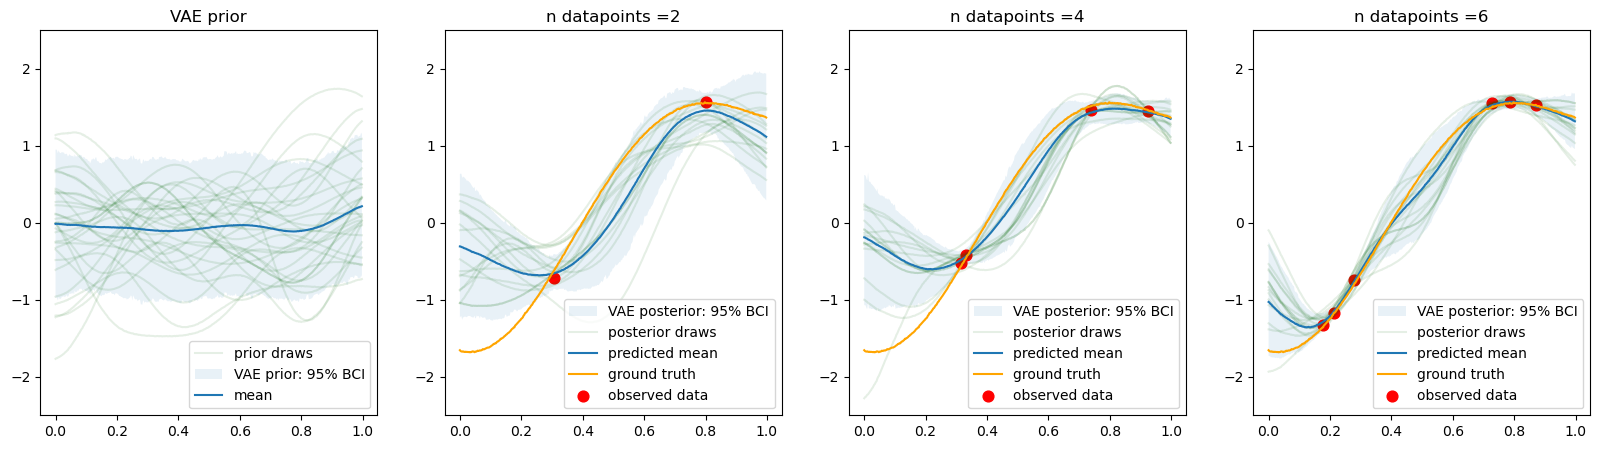

In [21]:
prior_predictive = Predictive(model_mcmc, num_samples=10000)
prior_predictions = prior_predictive(rng_key_prior, z_dim=args["z_dim"])["f"]
mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)


# plot results
fig, axs = plt.subplots(nrows=1, ncols=len(mean_post_pred_lst)+1, figsize=(20,5))
_min, _max = np.amin(mean_post_pred_lst), np.amax(mean_post_pred_lst)

N_lines = 30
for j in range(N_lines):
    axs[0].plot(args["x"], prior_predictions[j,:], alpha=0.1, color="darkgreen", label="")
axs[0].plot(args["x"], prior_predictions[0,:], alpha=0.1, color="darkgreen", label="prior draws")  
axs[0].fill_between(args["x"], hpdi_prior_pred[0], hpdi_prior_pred[1], alpha=0.1, interpolate=True, label="VAE prior: 95% BCI")
axs[0].plot(args["x"], mean_prior_pred, label="mean")
axs[0].legend(loc=4)
axs[0].set_ylim([-2.5, 2.5])
axs[0].set_title("VAE prior")

N_lines = 15
for i in range(len(mean_post_pred_lst)):
    axs[i+1].fill_between(args["x"], 
                      hpdi_post_pred_lst[i][0], hpdi_post_pred_lst[i][1], 
                      alpha=0.1, interpolate=True, label="VAE posterior: 95% BCI")
    for j in range(N_lines):
        axs[i+1].plot(args["x"], predictions_lst[i][j,:], alpha=0.1, color="darkgreen", label="")
    axs[i+1].plot(args["x"], predictions_lst[i][0,:], alpha=0.1, color="darkgreen", label="posterior draws")  
    axs[i+1].plot(args["x"], mean_post_pred_lst[i], label="predicted mean")
    axs[i+1].plot(args["x"], gp_draw, label="ground truth", color="orange")
    axs[i+1].scatter(x_obs_lst[i], y_obs_lst[i], color="red", label="observed data", s=60)
    axs[i+1].set_title("n datapoints =" + str(n_dats[i]))
    axs[i+1].legend(loc=4)
    axs[i+1].set_ylim([-2.5, 2.5])


#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_n{}_ndats.pdf'.format(n))

## Empirical covariance

Text(0.5, 1.0, 'VAE covariance matrix')

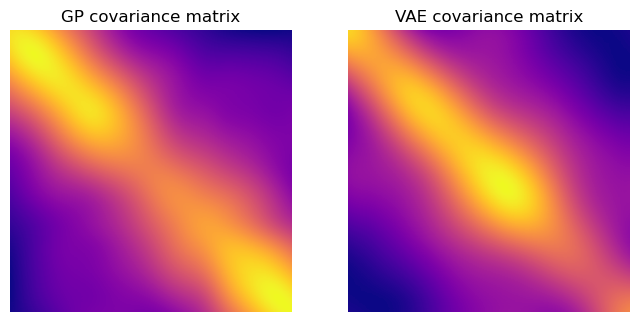

In [22]:
x = jnp.arange(0, 1, 1/args["n"])
rng_key, rng_key_predict = random.split(random.PRNGKey(6))
gp_predictive = Predictive(GP, num_samples=100)
gp_draws = gp_predictive(rng_key_predict, x=x, gp_kernel = args["gp_kernel"], jitter=1e-5)['y']
gp_draws = gp_draws[~np.isnan(gp_draws).any(axis=1), :]

rng_key, rng_key_predict = random.split(random.PRNGKey(6))
vae_predictive = Predictive(vae_sample, num_samples=100)
vae_draws = vae_predictive(rng_key_predict)['f']
#vae_draws[~np.isnan(gp_draws).any(axis=1), :]

m_vae = np.cov(np.transpose(vae_draws))
m_gp = np.cov(np.transpose(gp_draws))

cmap_choice = 'plasma'

#'plasma'
#'inferno'
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (8,4))
axs[0].imshow(m_gp, cmap=cmap_choice)
axs[0].axis('off')
axs[0].set_title('GP covariance matrix')

axs[1].imshow(m_vae, cmap=cmap_choice)
axs[1].axis('off')
axs[1].set_title('VAE covariance matrix')

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_cov_matrices.pdf')